## <center> Implied Volatility Dynamics </center> 

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd 

from numba import jit, prange
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt 

## <center> Set Seaborn Theme </center>

In [2]:
sns.set_theme(
    style = "darkgrid",
    palette = "bright",
)

plt.rc('figure', figsize = (10, 5))

## <center> Fetch DataFrame from Yahoo Finance </center> 

In [3]:
df = yf.download("VIXY VIXM UVXY ^VIX")
list(df.columns)

[*********************100%%**********************]  4 of 4 completed


[('Adj Close', 'UVXY'),
 ('Adj Close', 'VIXM'),
 ('Adj Close', 'VIXY'),
 ('Adj Close', '^VIX'),
 ('Close', 'UVXY'),
 ('Close', 'VIXM'),
 ('Close', 'VIXY'),
 ('Close', '^VIX'),
 ('High', 'UVXY'),
 ('High', 'VIXM'),
 ('High', 'VIXY'),
 ('High', '^VIX'),
 ('Low', 'UVXY'),
 ('Low', 'VIXM'),
 ('Low', 'VIXY'),
 ('Low', '^VIX'),
 ('Open', 'UVXY'),
 ('Open', 'VIXM'),
 ('Open', 'VIXY'),
 ('Open', '^VIX'),
 ('Volume', 'UVXY'),
 ('Volume', 'VIXM'),
 ('Volume', 'VIXY'),
 ('Volume', '^VIX')]

In [4]:
df = df[df["Adj Close", "UVXY"].notna()]

In [5]:
df.head()

Adj Close                                          Close  \
                    UVXY        VIXM      VIXY       ^VIX          UVXY   
Date                                                                      
2011-10-04  2.058000e+10  359.160004  226900.0  40.820000  2.058000e+10   
2011-10-05  1.813800e+10  352.399994  215320.0  37.810001  1.813800e+10   
2011-10-06  1.740000e+10  350.399994  211720.0  36.270000  1.740000e+10   
2011-10-07  1.765200e+10  355.559998  215560.0  36.200001  1.765200e+10   
2011-10-10  1.559400e+10  339.559998  199920.0  33.020000  1.559400e+10   

                                                     High              ...  \
                  VIXM      VIXY       ^VIX          UVXY        VIXM  ...   
Date                                                                   ...   
2011-10-04  359.160004  226900.0  40.820000  2.448000e+10  380.000000  ...   
2011-10-05  352.399994  215320.0  37.810001  1.989000e+10  360.920013  ...   
2011-10-06  350.399994  211720.0  36.270000  1.878000e+10  355.200012  ...   
2011-10-07  355.559998  215560.0  36.200001  1.857600e+10  358.480011  ...   
2011-10-10  339.559998  199920.0  33.020000  1.656000e+10  346.600006  ...   

                 Low                     Open                        \
                VIXY       ^VIX          UVXY        VIXM      VIXY   
Date                                                                  
2011-10-04  225400.0  40.020000  2.427000e+10  372.679993  249840.0   
2011-10-05  214440.0  37.509998  1.974600e+10  358.920013  223480.0   
2011-10-06  211400.0  36.150002  1.811400e+10  352.239990  216480.0   
2011-10-07  207440.0  35.189999  1.705800e+10  346.040009  207600.0   
2011-10-10  199840.0  32.959999  1.654800e+10  345.959991  206600.0   

                      Volume                      
                 ^VIX   UVXY    VIXM   VIXY ^VIX  
Date                                              
2011-10-04  46.180000    0.0  6975.0  337.0    0  
2011-10-05  40.730000    0.0  6250.0  181.0    0  
2011-10-06  38.240002    0.0  5250.0   97.0    0  
2011-10-07  35.669998    0.0  4525.0  225.0    0  
2011-10-10  35.450001    0.0  2400.0   95.0    0  

[5 rows x 24 columns]

In [6]:
df.tail()

Adj Close                               Close             \
                UVXY       VIXM       VIXY   ^VIX   UVXY       VIXM   
Date                                                                  
2023-09-07     14.72  18.959999  21.740000  14.40  14.72  18.959999   
2023-09-08     14.24  18.780001  21.309999  13.84  14.24  18.780001   
2023-09-11     13.77  18.440001  20.760000  13.80  13.77  18.440001   
2023-09-12     13.87  18.549999  20.920000  14.23  13.87  18.549999   
2023-09-13     13.49  18.469999  20.549999  13.48  13.49  18.469999   

                               High             ...        Low          Open  \
                 VIXY   ^VIX   UVXY       VIXM  ...       VIXY   ^VIX   UVXY   
Date                                            ...                            
2023-09-07  21.740000  14.40  15.69  19.420000  ...  21.590000  14.40  15.45   
2023-09-08  21.309999  13.84  14.65  18.950001  ...  20.950001  13.58  14.62   
2023-09-11  20.760000  13.80  14.19  18.709999  ...  20.680000  13.74  13.88   
2023-09-12  20.920000  14.23  14.07  18.549999  ...  20.549999  13.71  14.00   
2023-09-13  20.549999  13.48  13.78  18.530001  ...  20.389999  13.41  13.72   

                                             Volume                           
                 VIXM       VIXY   ^VIX        UVXY     VIXM       VIXY ^VIX  
Date                                                                          
2023-09-07  19.410000  22.459999  14.81  16921600.0  95800.0  2814200.0    0  
2023-09-08  18.950001  21.670000  14.22  15530000.0  37100.0  3085400.0    0  
2023-09-11  18.530001  20.900000  14.17  12373300.0  37700.0  2662400.0    0  
2023-09-12  18.480000  21.010000  14.02  14488900.0  22400.0  2616200.0    0  
2023-09-13  18.459999  20.730000  14.42  19109600.0  22400.0  2618600.0    0  

[5 rows x 24 columns]

## <center> Coefficient of Determination </center>

## <center> $ R^2 = 1 - \frac{\sum_{i=1}^{N} (y_{i} - f_{i})^2}{\sum_{i=1}^{N} (y_{i} - \hat{y})^2} $ </center>

In [7]:
@jit(nopython = True, parallel = True)
def compute_r2(y, y_hat):
    """
    
    """
    
    RSS = np.sum((y - y_hat)**2)
    TSS = np.sum((y_hat - np.mean(y_hat))**2)
    
    R2 = 1 - (RSS / TSS)
    
    return R2

In [8]:
@jit(nopython = True, parallel = True)
def compute_log_returns(arr):
    
    N = len(arr)
    series = np.zeros(N - 1)
    
    for i in prange(N - 1):
        series[i] = np.log(arr[i + 1] / arr[i]) * 100
        
    return series

In [9]:
@jit(nopython = True, parallel = True)
def compute_intraday_log_returns(close_price, open_price):
    
    N = len(close_price)
    series = np.zeros(N)
    
    for i in prange(N):
        series[i] = np.log(close_price[i] / open_price[i]) * 100
        
    return series

In [10]:
vixm_open_returns = compute_log_returns(df["Open", "VIXM"].to_numpy())
vixy_open_returns = compute_log_returns(df["Open", "VIXY"].to_numpy())
uvxy_open_returns = compute_log_returns(df["Open", "UVXY"].to_numpy())
ivol_open_returns = compute_log_returns(df["Open", "^VIX"].to_numpy())

vixm_close_returns = compute_log_returns(df["Adj Close", "VIXM"].to_numpy())
vixy_close_returns = compute_log_returns(df["Adj Close", "VIXY"].to_numpy())
uvxy_close_returns = compute_log_returns(df["Adj Close", "UVXY"].to_numpy())
ivol_close_returns = compute_log_returns(df["Adj Close", "^VIX"].to_numpy())

vixm_intraday = compute_intraday_log_returns(df["Open", "VIXM"].to_numpy(), df["Close", "VIXM"].to_numpy())
vixy_intraday = compute_intraday_log_returns(df["Open", "VIXY"].to_numpy(), df["Close", "VIXY"].to_numpy())
uvxy_intraday = compute_intraday_log_returns(df["Open", "UVXY"].to_numpy(), df["Close", "UVXY"].to_numpy())
ivol_intraday = compute_intraday_log_returns(df["Open", "^VIX"].to_numpy(), df["Close", "^VIX"].to_numpy())

## <center> Plot Data, Visualize Joint Distribution </center> 

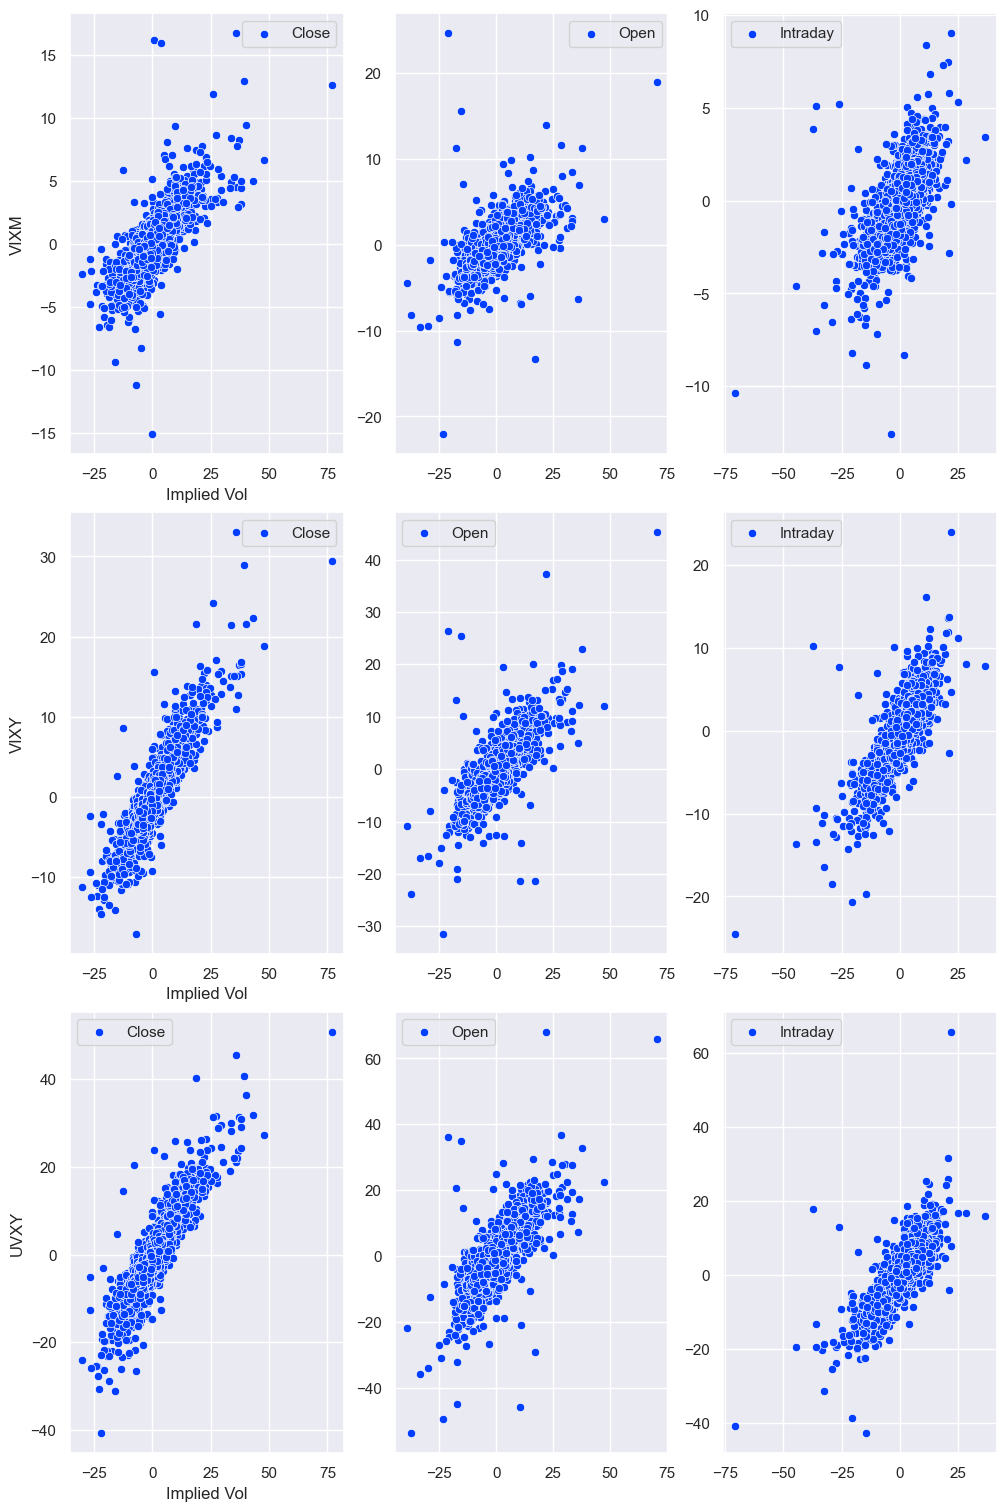

In [11]:
fig, axes = plt.subplots(3, 3, figsize = (10, 15), constrained_layout = True)

ax1 = sns.scatterplot(
    x = ivol_close_returns,
    y = vixm_close_returns,
    ax = axes[0, 0],
    label = "Close"
)

sns.scatterplot(
    x = ivol_open_returns,
    y = vixm_open_returns,
    ax = axes[0, 1],
    label = "Open"
)

sns.scatterplot(
    x = ivol_intraday,
    y = vixm_intraday,
    ax = axes[0, 2],
    label = "Intraday"
)

ax1.set(
    xlabel = "Implied Vol",
    ylabel = "VIXM",
)

ax2 = sns.scatterplot(
    x = ivol_close_returns,
    y = vixy_close_returns,
    ax = axes[1, 0],
    label = "Close"
)

sns.scatterplot(
    x = ivol_open_returns,
    y = vixy_open_returns,
    ax = axes[1, 1],
    label = "Open"
)

sns.scatterplot(
    x = ivol_intraday,
    y = vixy_intraday,
    ax = axes[1, 2],
    label = "Intraday"
)

ax2.set(
    xlabel = "Implied Vol",
    ylabel = "VIXY",
)

ax2 = sns.scatterplot(
    x = ivol_close_returns,
    y = uvxy_close_returns,
    ax = axes[2, 0],
    label = "Close"
)

sns.scatterplot(
    x = ivol_open_returns,
    y = uvxy_open_returns,
    ax = axes[2, 1],
    label = "Open"
)

sns.scatterplot(
    x = ivol_intraday,
    y = uvxy_intraday,
    ax = axes[2, 2],
    label = "Intraday"
)

ax2.set(
    xlabel = "Implied Vol",
    ylabel = "UVXY",
)

plt.show()

## <center> Squared Error </center> 

## <center> $ L(\theta) = \frac{1}{N} \sum_{i=1}^{N} ((x_{i} \beta) - \hat{x})^{2} $ </center> 

## <center> $ \nabla(\beta) = \frac{2}{N} \sum_{i=1}^{N} ((x_{i} \beta) - \hat{x}) \cdot x_{i} $ </center> 

In [12]:
@jit(nopython = True, parallel = True)
def squared_error_regression(X, y):
    """
    
    """
    
    err_tol = 1e-7
    
    L = len(X)
    beta = -0.5
    gamma = 0.01
    gradient = 1
    itr_count = 0
    
    while np.abs(gradient) > err_tol:
        
        for i in prange(L):
            gradient += ((X[i] * beta) - y[i]) * X[i]

        gradient *= 2 / L
        beta = beta - gamma * gradient
        itr_count += 1
    
    print("Squared Error Regression Iteration Count: ", itr_count)
    
    return beta

In [13]:
squared_error_scores = []

slope = squared_error_regression(ivol_close_returns, vixm_close_returns)
squared_error_prediction = slope * ivol_close_returns
squared_r2 = compute_r2(squared_error_prediction, vixm_close_returns)
squared_error_scores.append(squared_r2)

slope = squared_error_regression(ivol_close_returns, vixy_close_returns)
squared_error_prediction = slope * ivol_close_returns
squared_r2 = compute_r2(squared_error_prediction, vixy_close_returns)
squared_error_scores.append(squared_r2)

slope = squared_error_regression(ivol_close_returns, uvxy_close_returns)
squared_error_prediction = slope * ivol_close_returns
squared_r2 = compute_r2(squared_error_prediction, uvxy_close_returns)
squared_error_scores.append(squared_r2)

Squared Error Regression Iteration Count:  14
Squared Error Regression Iteration Count:  14
Squared Error Regression Iteration Count:  15


## <center> Log Cosh </center>

## <center> $ L(\theta) = \frac{1}{N} \sum_{i=1}^{N} log(cosh((x_{i} \beta) - \hat{x})) $ </center>

## <center> $ \nabla(\beta) = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{cosh((x_{i} \beta) - \hat{x})} sinh((x_{i} \beta) - \hat{x}) \cdot x_{i} $ </center>

In [14]:
@jit(nopython = True, parallel = True)
def log_cosh_error_regression(X, y):
    """
    
    """
    
    err_tol = 1e-7
    
    L = len(X)
    beta = -0.50
    gamma = 0.05
    gradient = 1
    itr_count = 0
    
    while np.abs(gradient) > err_tol:
        
        for i in prange(L):
            gradient += (1 / np.cosh((X[i] * beta) - y[i])) * np.sinh((X[i] * beta) - y[i]) * X[i]

        gradient *= 1 / L
        beta = beta - gamma * gradient
        itr_count += 1
    
    print("Log Cosh Error Regression Iteration Count: ", itr_count)
    
    return beta

In [15]:
log_cosh_error_scores = []

slope = log_cosh_error_regression(ivol_close_returns, vixm_close_returns)
log_cosh_error_prediction = slope * ivol_close_returns
squared_r2 = compute_r2(log_cosh_error_prediction, vixm_close_returns)
log_cosh_error_scores.append(squared_r2)

slope = log_cosh_error_regression(ivol_close_returns, vixy_close_returns)
log_cosh_error_prediction = slope * ivol_close_returns
squared_r2 = compute_r2(log_cosh_error_prediction, vixy_close_returns)
log_cosh_error_scores.append(squared_r2)

slope = log_cosh_error_regression(ivol_close_returns, uvxy_close_returns)
log_cosh_error_prediction = slope * ivol_close_returns
squared_r2 = compute_r2(log_cosh_error_prediction, uvxy_close_returns)
log_cosh_error_scores.append(squared_r2)

Log Cosh Error Regression Iteration Count:  17
Log Cosh Error Regression Iteration Count:  10
Log Cosh Error Regression Iteration Count:  24


## <center> Huber Loss </center> 

## <center> $ L(\theta) = \begin{cases}
        \frac{1}{N} \sum_{i=1}^{N} \frac{1}{2} ((x_{i} \beta) - \hat{x})^2 & \text{if } |(x_{i} \beta) - \hat{x}| \leq \delta \\
        \frac{1}{N} \sum_{i=1}^{N} \delta (|(x_{i} \beta) - \hat{x}| - \frac{1}{2} \delta) & \text{if } |(x_{i} \beta) - \hat{x}| \gt \delta
    \end{cases} $ </center> 
    
## <center> $ \nabla(\beta) = \begin{cases}
        \frac{1}{N} \sum_{i=1}^{N} ((x_{i} \beta) - \hat{x}) \cdot x_{i} & \text{if } |(x_{i} \beta) - \hat{x}| \leq \delta \\
        \frac{1}{N} \sum_{i=1}^{N} \delta \frac{1}{|(x_{i} \beta) - \hat{x}|} \cdot x_{i} & \text{if } |(x_{i} \beta) - \hat{x}| \gt \delta
    \end{cases} $ </center> 

In [16]:
@jit(nopython = True, parallel = True)
def huber_error_regression(X, y, delta):
    """
    
    """
    
    err_tol = 1e-7
    
    L = len(X)
    beta = -0.50
    gamma = 0.01
    gradient = 1
    itr_count = 0
    
    while np.abs(gradient) > err_tol:
        
        for i in prange(L):
            
            x = np.abs(X[i] * beta - y[i])
            
            if x <= delta:
                gradient += (X[i] * beta - y[i]) * X[i]
            else:
                gradient += delta * (1 / (X[i] * beta - y[i])) * X[i]

        gradient *= 1 / L
        beta = beta - gamma * gradient
        itr_count += 1
    
    print("Huber Error Regression Iteration Count: ", itr_count)
    
    return beta

In [17]:
huber_error_scores = []

slope = huber_error_regression(ivol_close_returns, vixm_close_returns, delta = 2)
huber_error_prediction = slope * ivol_close_returns
squared_r2 = compute_r2(huber_error_prediction, vixm_close_returns)
huber_error_scores.append(squared_r2)

slope = huber_error_regression(ivol_close_returns, vixy_close_returns, delta = 2)
huber_error_prediction = slope * ivol_close_returns
squared_r2 = compute_r2(huber_error_prediction, vixy_close_returns)
huber_error_scores.append(squared_r2)

slope = huber_error_regression(ivol_close_returns, uvxy_close_returns, delta = 2)
huber_error_prediction = slope * ivol_close_returns
squared_r2 = compute_r2(huber_error_prediction, uvxy_close_returns)
huber_error_scores.append(squared_r2)

Huber Error Regression Iteration Count:  55
Huber Error Regression Iteration Count:  92
Huber Error Regression Iteration Count:  182


## <center> Squared Logarithmic Error </center> 

## <center> $ L(\theta) = \frac{1}{N} \sum_{i=1}^{N} log(((x_{i} \beta) - \hat{x})^{2} + 1) $ </center>

## <center> $ \nabla(\beta) = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{((x_{i} \beta) - \hat{x})^{2}} \cdot 2((x_{i} \beta) - \hat{x}) \cdot x_{i} $ </center>

In [18]:
@jit(nopython = True, parallel = True)
def squared_log_error_regression(X, y):
    """
    
    """
    
    err_tol = 1e-7
    
    L = len(X)
    beta = -0.50
    gamma = 0.01
    gradient = 1
    itr_count = 0
    
    while np.abs(gradient) > err_tol:
        
        for i in prange(L):
            gradient += (1 / (((X[i] * beta) - y[i])**2 + 1)) * 2 * ((X[i] * beta) - y[i]) * X[i]

        gradient *= 1 / L
        beta = beta - gamma * gradient
        itr_count += 1
    
    print("Squared Log Error Regression Iteration Count: ", itr_count)
    
    return beta

In [19]:
squared_log_error_scores = []

slope = squared_log_error_regression(ivol_close_returns, vixm_close_returns)
squared_log_error_prediction = slope * ivol_close_returns
squared_r2 = compute_r2(squared_log_error_prediction, vixm_close_returns)
squared_log_error_scores.append(squared_r2)

slope = squared_log_error_regression(ivol_close_returns, vixy_close_returns)
squared_log_error_prediction = slope * ivol_close_returns
squared_r2 = compute_r2(squared_log_error_prediction, vixy_close_returns)
squared_log_error_scores.append(squared_r2)

slope = squared_log_error_regression(ivol_close_returns, uvxy_close_returns)
squared_log_error_prediction = slope * ivol_close_returns
squared_r2 = compute_r2(squared_log_error_prediction, uvxy_close_returns)
squared_log_error_scores.append(squared_r2)

Squared Log Error Regression Iteration Count:  86
Squared Log Error Regression Iteration Count:  140
Squared Log Error Regression Iteration Count:  265


## <center> Results DataFrame </center> 

In [20]:
R2 = pd.DataFrame({
    "Squared R2" : squared_error_scores, 
    "Log Cosh R2" : log_cosh_error_scores,
    "Huber R2" : huber_error_scores,
    "Squared Log R2" : squared_log_error_scores,
}, index = ["SPY", "VIXY", "UVXY"])

In [21]:
display(R2)

,Squared R2,Log Cosh R2,Huber R2,Squared Log R2
SPY,0.578108,0.577556,0.576957,0.576702
VIXY,0.799883,0.799660,0.799363,0.799307
UVXY,0.779902,0.779094,0.777090,0.777068


## <center> Optimal Model Selection </center> 

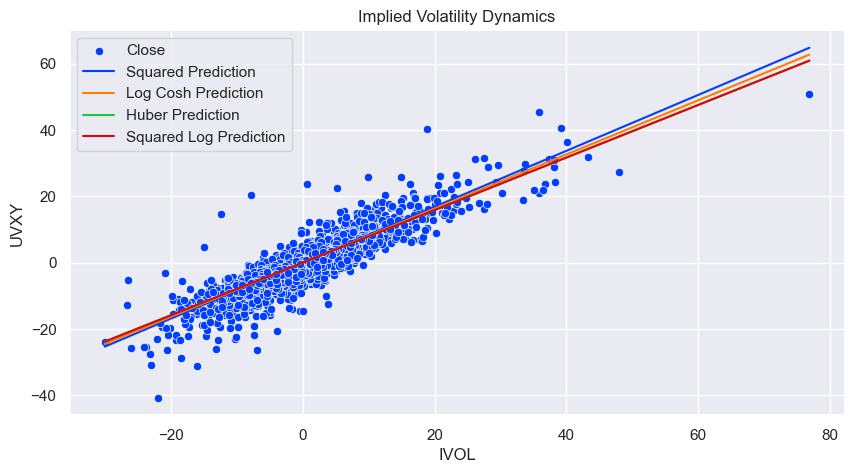

In [22]:
ax = sns.scatterplot(
    x = ivol_close_returns,
    y = uvxy_close_returns,
    label = "Close"
)

sns.lineplot(
    x = ivol_close_returns,
    y = squared_error_prediction,
    label = "Squared Prediction",
)

sns.lineplot(
    x = ivol_close_returns,
    y = log_cosh_error_prediction,
    label = "Log Cosh Prediction",
)

sns.lineplot(
    x = ivol_close_returns,
    y = huber_error_prediction,
    label = "Huber Prediction",
)

sns.lineplot(
    x = ivol_close_returns,
    y = squared_log_error_prediction,
    label = "Squared Log Prediction",
)

ax.set(
    title = "Implied Volatility Dynamics",
    xlabel = "IVOL",
    ylabel = "UVXY",
)

plt.show()